Data loaded successfully. First 5 rows:


,image,caption,label
0,meme1.jpg,This is too funny!,Funny
1,meme2.jpg,"Ugh, not again",Cringe
2,meme3.jpg,Just a regular day,Neutral
3,meme4.jpg,When the code finally works,Funny
4,meme5.jpg,Seriously?,Cringe



After text preprocessing:


,caption,clean_caption
0,This is too funny!,funny
1,"Ugh, not again",ugh
2,Just a regular day,regular day
3,When the code finally works,code finally works
4,Seriously?,seriously


Training samples: 12
Test samples: 3
Classification Report:
              precision    recall  f1-score   support

      Cringe       0.00      0.00      0.00         1
       Funny       0.33      1.00      0.50         1
     Neutral       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3


Testing on new memes:
Caption: "When you finally finish your assignment"
Cleaned: "finally finish assignment"
Predicted Sentiment: Funny

Caption: "Why does this always happen to me?"
Cleaned: "always happen"
Predicted Sentiment: Cringe

Caption: "Just another boring day"
Cleaned: "another boring day"
Predicted Sentiment: Neutral


Sample memes with predictions:


C:\Users\balaj\anaconda3\envs\AiMl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\balaj\anaconda3\envs\AiMl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\balaj\anaconda3\envs\AiMl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


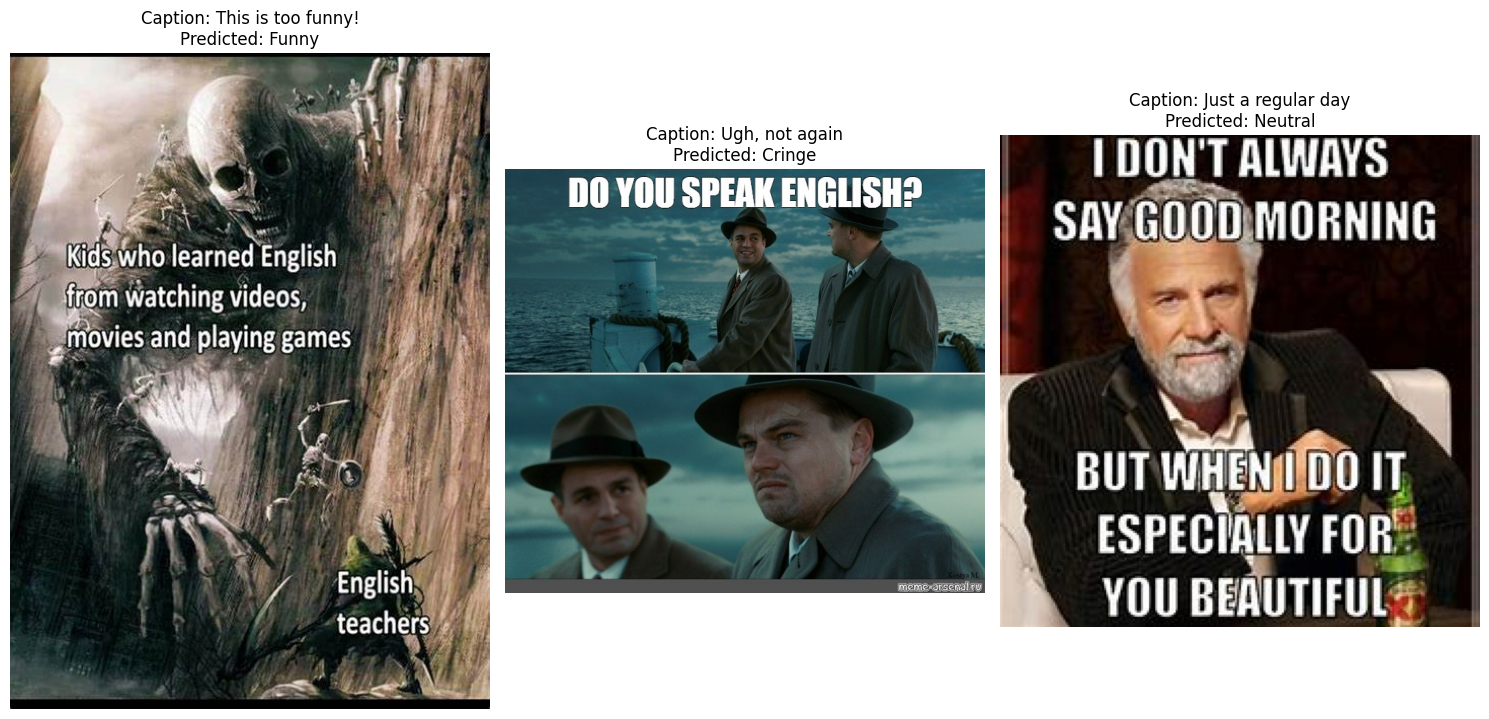

Predictions successfully saved to meme_dataset/meme_predictions.csv


In [1]:

# This notebook classifies meme sentiment based on caption text using TF-IDF and Logistic Regression.
# Import required libraries
import os
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords

# %%
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# %%
def preprocess_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing stopwords
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(tokens)


# ## 1. Load and Prepare Data

# %%
# Load the CSV file
try:
    df = pd.read_csv('meme_dataset/meme_data.csv')
    print("Data loaded successfully. First 5 rows:")
    display(df.head())
except FileNotFoundError:
    print("Error: File not found. Please ensure 'meme_dataset/meme_data.csv' exists.")
    # Create sample data if file not found
    data = {
        'image': ['meme1.jpg', 'meme2.jpg', 'meme3.jpg'],
        'caption': [
            "This is so funny!",
            "Ugh, not again",
            "Why does this always happen to me?"
        ],
        'label': ['FUNNY', 'CRINGE', 'CRINGE']
    }
    df = pd.DataFrame(data)
    print("Using sample data instead:")
    display(df)

# %%
# Preprocess the captions
df['clean_caption'] = df['caption'].apply(preprocess_text)
print("\nAfter text preprocessing:")
display(df[['caption', 'clean_caption']].head())


# ## 2. Train the Model

# %%
# Split data into train and test sets
X = df['clean_caption']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=42, 
    test_size=0.2,
    stratify=y  # Maintain class distribution
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# %%
# Create pipeline: TF-IDF + Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)


# ## 3. Evaluate the Model

# %%
# Make predictions and print classification report
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
# ## 4. Test with New Memes

# %%
# Test on new meme captions
new_memes = [
    "When you finally finish your assignment",
    "Why does this always happen to me?",
    "Just another boring day"
]

print("\nTesting on new memes:")
for caption in new_memes:
    processed = preprocess_text(caption)
    prediction = pipeline.predict([processed])[0]
    print(f'Caption: "{caption}"')
    print(f'Cleaned: "{processed}"')
    print(f'Predicted Sentiment: {prediction}\n')


# ## 5. Visualize Results

# %%
# Display sample memes with predictions
print("\nSample memes with predictions:")
plt.figure(figsize=(15, 10))

for idx, row in df.iloc[:3].iterrows():
    img_path = os.path.join('meme_dataset', row['image'])
    
    plt.subplot(1, 3, idx+1)
    try:
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            plt.imshow(img)
        else:
            # Create placeholder if image not found
            plt.text(0.5, 0.5, 'Image not found', 
                    ha='center', va='center', fontsize=12)
    except Exception as e:
        plt.text(0.5, 0.5, f'Error loading image\n{str(e)}', 
                ha='center', va='center', fontsize=10)
    
    plt.axis('off')
    pred = pipeline.predict([row['clean_caption']])[0]
    plt.title(f"Caption: {row['caption']}\nPredicted: {pred}")

plt.tight_layout()
plt.show()


# ## 6. Save Predictions

# %%
# Save predictions to CSV
df['prediction'] = pipeline.predict(df['clean_caption'])
output_path = 'meme_dataset/meme_predictions.csv'

try:
    df[['image', 'caption', 'prediction']].to_csv(output_path, index=False)
    print(f"Predictions successfully saved to {output_path}")
except Exception as e:
    print(f"Error saving predictions: {e}")
    print("Showing predictions dataframe instead:")
    display(df[['image', 'caption', 'prediction']])